In [3]:
from pymongo import MongoClient
import pandas as pd
from parse_clean_store import (parse_route_page, parse_user, create_ratings_matrix)
from bs4 import BeautifulSoup
import json
import numpy as np
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
%matplotlib inline
from ggplot import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import pyspark
from pyspark.sql.types import *
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.ml.recommendation import ALS, ALSModel
from pyspark.ml.evaluation import RegressionEvaluator

In [5]:
# Build our Spark Session and Context
spark = pyspark.sql.SparkSession.builder.getOrCreate()
sc = spark.sparkContext
spark, sc

(<pyspark.sql.session.SparkSession at 0x7f7e97fd75d0>,
 <pyspark.context.SparkContext at 0x7f7e97efd610>)

In [57]:
client = MongoClient('mongodb://localhost:27017/')
db = client.ratings_collection
ratings_collection = db.ratings_collection
raw_data = ratings_collection.find()
df_ratings = pd.DataFrame(list(raw_data))
df_ratings.head()

,_id,rating,route,username
0,58c87f8c40b44102a84aedfb,[1],30(1) Feet of Pleasure,[adam winslow ]
1,58c87f9d40b44102a84aee01,[1],41 Feet of Pain,[adam winslow ]
2,58c87fac40b44102a84aee07,"[1, 1, 1, 1]",5.5 Crack,"[CHopwood , Trevor. , Rickedge , Oscar Edge ]"
3,58c87fb440b44102a84aee0d,"[3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",5.6 crack,"[Bianca P , Sandeep Kumar , Mike Brady , Tom B..."
4,58c87fbf40b44102a84aee13,"[2, 2, 2, 2, 1, 1, 1, 1, 1]",5.6 Dihedral,"[Jason Killgore , sqwirll , Dave Leydet , fort..."


In [104]:
ratings_df_pd = create_ratings_matrix(df_ratings)
ratings_df_pd.head()

,route_id,user_id,rating
0,0,0,1
1,1,0,1
2,2,1,1
3,2,2,1
4,2,3,1


In [107]:
df =ratings_df_pd

In [118]:
# save to mongodb
client = MongoClient('mongodb://localhost:27017/')
db = client.ratings
ratings = db.ratings
ratings_df_pd.to_json(orient='records')
list_dict = json.loads(ratings_df_pd.to_json(orient='records'))
ratings.insert_many(list_dict)

In [126]:
client = MongoClient('mongodb://localhost:27017/')
db = client.ratings
ratings_df_pd = pd.DataFrame(list(db.ratings.find())).drop("_id", axis=1)

In [127]:
ratings_df_pd.shape

(29770, 3)

In [128]:
# Convert to a Spark DataFrame
ratings_df = spark.createDataFrame(ratings_df_pd)

In [129]:
# Check to see we built the DataFrame
ratings_df

DataFrame[rating: bigint, route_id: bigint, user_id: bigint]

In [130]:
# Take a look at the entries in the DataFrame
ratings_df.show(5)

+------+--------+-------+
|rating|route_id|user_id|
+------+--------+-------+
|     1|       0|      0|
|     1|       1|      0|
|     1|       2|      1|
|     1|       2|      2|
|     1|       2|      3|
+------+--------+-------+
only showing top 5 rows



In [112]:
train, test = ratings_df.randomSplit([0.8, 0.2], seed=427471138)

In [113]:
# Check to see our split worked
train.count(), test.count()

(3, 2)

In [64]:
als_model = ALS(userCol='route_id',
                itemCol='user_id',
                ratingCol='rating',
                nonnegative=True,
                regParam=0.1,
                rank=10
               )

In [65]:
recommender = als_model.fit(train)

In [14]:
path = '/home/david/work/project/Rock-Climbing-Route-Recommender/src/alsmodel'

In [15]:
recommender.save(path)

NameError: name 'recommender' is not defined

In [66]:
recommender = ALSModel.load(path)

In [67]:
# test on new user
# Build a single row DataFrame
data = [(1, 500)]
columns = ('route_id', 'user_id')
one_row_spark_df = spark.createDataFrame(data, columns)
# Get the recommender's prediction
recommender.transform(one_row_spark_df).show()

+--------+-------+----------+
|route_id|user_id|prediction|
+--------+-------+----------+
|       1|    500|0.49262786|
+--------+-------+----------+



In [68]:
# Build a single row DataFrame
data = pd.DataFrame(columns=['route_id', 'user_id'])
data['user_id'] = np.ones(ratings_df_pd['route_id'].shape,dtype=int).tolist()
data['route_id'] = ratings_df_pd['route_id'].tolist()
one_row_spark_df = spark.createDataFrame(data)
pred = recommender.transform(one_row_spark_df).toPandas()

In [69]:
pred.sort_values('prediction', ascending=False).head()

,route_id,user_id,prediction
23664,2639,1,3.486598
23667,2639,1,3.486598
23660,2639,1,3.486598
23661,2639,1,3.486598
23662,2639,1,3.486598


In [70]:
# Check that it worked
one_row_spark_df.show()

+--------+-------+
|route_id|user_id|
+--------+-------+
|       0|      1|
|       1|      1|
|       2|      1|
|       2|      1|
|       2|      1|
|       2|      1|
|       3|      1|
|       3|      1|
|       3|      1|
|       3|      1|
|       3|      1|
|       3|      1|
|       3|      1|
|       3|      1|
|       3|      1|
|       3|      1|
|       3|      1|
|       3|      1|
|       3|      1|
|       3|      1|
+--------+-------+
only showing top 20 rows



In [71]:
# Get the factors for user 1 and route 100
user_factor_df = recommender.userFactors.filter('id = 1')
item_factor_df = recommender.itemFactors.filter('id = 100')

In [72]:
user_factors = user_factor_df.collect()[0]['features']
item_factors = item_factor_df.collect()[0]['features']

In [73]:
# Manually (sorta) calculate the predicted rating
np.dot(user_factors, item_factors)

0.71798355074396636

In [74]:
# Get the recommender's prediction
recommender.transform(one_row_spark_df).show()

+--------+-------+----------+
|route_id|user_id|prediction|
+--------+-------+----------+
|       0|      1|       NaN|
|       1|      1|0.61440986|
|       2|      1|0.94786185|
|       2|      1|0.94786185|
|       2|      1|0.94786185|
|       2|      1|0.94786185|
|       3|      1| 1.7534399|
|       3|      1| 1.7534399|
|       3|      1| 1.7534399|
|       3|      1| 1.7534399|
|       3|      1| 1.7534399|
|       3|      1| 1.7534399|
|       3|      1| 1.7534399|
|       3|      1| 1.7534399|
|       3|      1| 1.7534399|
|       3|      1| 1.7534399|
|       3|      1| 1.7534399|
|       3|      1| 1.7534399|
|       3|      1| 1.7534399|
|       3|      1| 1.7534399|
+--------+-------+----------+
only showing top 20 rows



In [75]:
# Let's take a look all the user factors
recommender.userFactors.show()

+---+--------------------+
| id|            features|
+---+--------------------+
| 10|[0.08819726, 0.62...|
| 20|[0.46378946, 0.19...|
| 30|[0.6151641, 0.0, ...|
| 40|[0.34406647, 0.33...|
| 50|[0.0, 1.2258581, ...|
| 60|[0.25804183, 0.36...|
| 70|[0.30531475, 0.38...|
| 80|[0.34970313, 0.60...|
| 90|[0.15161109, 0.46...|
|100|[0.34406647, 0.33...|
|110|[0.5062833, 0.450...|
|120|[0.27724603, 0.36...|
|130|[0.26220086, 0.0,...|
|140|[0.7070087, 0.231...|
|150|[0.18852422, 0.14...|
|160|[0.37174568, 0.16...|
|170|[0.6958353, 0.136...|
|180|[0.525305, 0.3258...|
|200|[0.18795294, 0.22...|
|210|[0.34406647, 0.33...|
+---+--------------------+
only showing top 20 rows



In [76]:
# Make predictions for the whole test set
predictions = recommender.transform(test)

In [77]:
type(recommender)

pyspark.ml.recommendation.ALSModel

In [78]:
# Dump the predictions to Pandas DataFrames to make our final calculations easier
predictions_df = predictions.toPandas()
train_df = train.toPandas()

In [79]:
# Fill any missing values with the mean rating
# There are multiple things you could fill with, this is just one example
predictions_df = predictions.toPandas().fillna(train_df['rating'].mean())

In [80]:
predictions_df['squared_error'] = (predictions_df['rating'] - predictions_df['prediction'])**2

In [81]:
predictions_df.describe()

,route_id,user_id,rating,prediction,squared_error
count,6014.000000,6014.000000,6014.000000,6014.000000,6.014000e+03
mean,1680.289657,513.121383,2.733788,2.529509,5.286648e-01
std,998.657426,498.921735,0.895950,0.711748,8.046094e-01
min,0.000000,0.000000,0.000000,0.000000,1.892482e-08
25%,842.000000,110.000000,2.000000,2.039620,5.930804e-02
50%,1578.500000,353.500000,3.000000,2.603309,2.240751e-01
75%,2481.000000,759.000000,3.000000,3.013358,6.288728e-01
max,3724.000000,2065.000000,4.000000,5.026344,1.085748e+01


In [82]:
# Calculate RMSE
np.sqrt(sum(predictions_df['squared_error']) / len(predictions_df))

0.7270933846403661

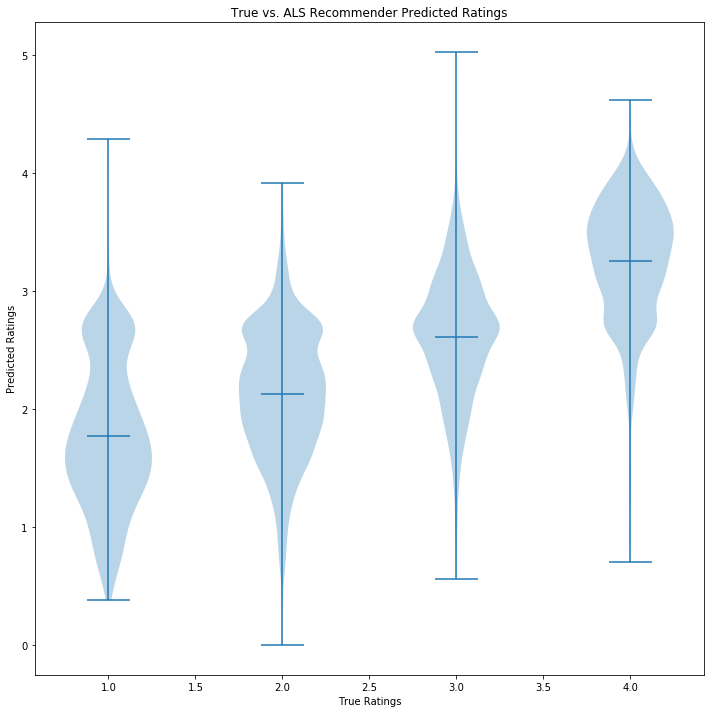

In [141]:
# Create array of predictions for violinplot
data = [predictions_df['prediction'][predictions_df['rating'] == rating] for rating in range(1, 5)]

fig, ax = plt.subplots(1, figsize=(12,12))
ax.violinplot(data, range(1,5), showmeans=True)
ax.set_xlabel('True Ratings')
ax.set_ylabel('Predicted Ratings')
ax.set_title('True vs. ALS Recommender Predicted Ratings')
plt.show()

In [143]:
fig.savefig('violin.jpg')

In [33]:
# see comparision to just average rating
test_df = test.toPandas()
test_df['prediction'] = train_df['rating'].mean()
test_df['squared_error'] = (test_df['rating'] - test_df['prediction'])**2
test_df.head()

,rating,route_id,user_id,prediction,squared_error
0,1,0,0,1.0,0.0
1,1,1,0,1.0,0.0


In [34]:
# Calculate RMSE
np.sqrt(sum(test_df['squared_error']) / len(test_df))

0.0

In [41]:
# see comparision to average rating per route
test_df = test.toPandas()
for route_id in test_df['route_id']:
    test_df['prediction'] = train_df[train_df['route_id']==route_id]['rating'].mean()
test_df['squared_error'] = (test_df['rating'] - test_df['prediction'])**2
# Calculate RMSE
np.sqrt(sum(test_df['squared_error']) / len(test_df))

nan

In [41]:
def get_route_list():
    client = MongoClient('mongodb://localhost:27017/')
    db = client.ratings_collection
    ratings_collection = db.ratings_collection
    collection = ratings_collection.find({"route": {'$exists' : True }})
    route_list = [d['route'].encode('utf-8').lower() for d in list(collection)]
    return route_list

def find_routes_in_list(routes, ratings):
    route_list = get_route_list()
    # drop caps
    routes = routes
    routes_numeric = []
    for route in routes:
        if route.lower() not in route_list:
            # remove from ratings and routes
            ratings.pop(routes.index(route))
            routes.remove(route)
        else:
            routes_numeric.append(route_list.index(route.lower()))
    return routes_numeric, ratings

def build_dataframe(routes, ratings):
    routes, ratings = find_routes_in_list(routes, ratings)
    # make up username
    data = [(66666, route, rating) for route, rating in zip(routes, ratings)]
    columns = ('username', 'route', 'rating')
    return spark.createDataFrame(data, columns)

routes = ['godzilla', 'Aires', 'Breakfast of Champions', 'cultureshock','bendsdsd']
ratings = [4,3,4,4,3]
predict_df = build_dataframe(routes, ratings)
recommender.transform(predict_df).show()

+--------+-----+------+----------+
|username|route|rating|prediction|
+--------+-----+------+----------+
|   66666|  955|     4|       NaN|
|   66666|  684|     3|       NaN|
|   66666| 1704|     4|       NaN|
|   66666| 3473|     4|       NaN|
+--------+-----+------+----------+

